# Exploratory Data Analysis of CDP dataset 


Se the documentation of the dataset [here](https://github.com/OpenGeoScales/ogs-data-exploration/blob/main/data/ghg-emissions/cdp/README.md) for more details on the data source and methods of calculations

### Summary :
0. Stacking every yearly report
1. Missing values
2. Geospacial coverage
3. Temporal coverage
4. Emissions analysis
5. Gases included

**To Do :**
- [ ] apply preprocessing for measurement year
- [x] stack all yearly report (maybe rename every columns to a reference list and create missing columns, then stack)
- [x] geospacial analysis
- [x] update geospacial analysis considering that many cities do not have any emissions
- [x] create new columns scope_1, Scope_2 and Scope_3 with the total value of emissions
- [ ] check what are BASIC emissions (and check if there are cases with BASIC but not Scope_X)
- [ ] analysis of emissions time series (min/max, distribution)

Also :
- [ ] see why we have duplicates in the same year report
- [ ] Missing cities: extract city name from "Organization" by matching it with a reference list (of cities names per country)
- [ ] plot cities in a map to assert that coordinates are actually true (do it for some countries)

### Steps of preprocessing needed for each dataset: (draft)
Year of measurement should be handled differently to the report:
- split accounting year start/end for 13; 17-20
- clean measurement year for 15; 16
- already clean for 12; 14

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
data_17 = pd.read_csv("../../../data/ghg-emissions/cdp/2017_-_Cities_Community_Wide_Emissions.csv")
data_16 = pd.read_csv("../../../data/ghg-emissions/cdp/2016_-_Citywide_GHG_Emissions.csv")
data_15 = pd.read_csv("../../../data/ghg-emissions/cdp/2015_-_Citywide_Emissions.csv")
data_14 = pd.read_csv("../../../data/ghg-emissions/cdp/2014_-_Citywide_GHG_Emissions.csv")
data_13 = pd.read_csv("../../../data/ghg-emissions/cdp/Citywide_GHG_Emissions_2013.csv")
data_12 = pd.read_csv("../../../data/ghg-emissions/cdp/2012_-_Citywide_GHG_Emissions.csv")

data_18 = pd.read_csv("../../../data/ghg-emissions/cdp/2018_-_2019_City-wide_Emissions.csv")
data_19 = pd.read_csv("../../../data/ghg-emissions/cdp/2019_City-wide_Emissions.csv")
data_20 = pd.read_csv("../../../data/ghg-emissions/cdp/2020_-_City-Wide_Emissions.csv")


In [150]:
cols_mapping = pd.read_excel("../../../data/ghg-emissions/cdp/columns_mapping.xls", sheet_name='Sheet1')

# Preprocessing Accounting year

# Stacking all the reports

Every reports has : a different number of columns, different columns names, and set in a different order
Here we use the mapping file `columns_mapping.xlsx` to rename columns in the same referential and thus be able to combine all reports into one dataframe.

In [151]:
# This is the mapping file that shows which columns is present per report
cols_mapping

,Mapped Columns,2012,2013,2014,2015,2016,2017,2018,2019,2020,Commentaires
0,Reporting year,Reporting Year,Reporting Year,Reporting Year,Reporting Year,Reporting Year,Reporting year,Year Reported to CDP,Year Reported to CDP,Year Reported to CDP,NaN
1,Account number,Account No,Account No,Account No,Account No,Account Number,Account number,Account Number,Account Number,Account Number,NaN
2,Organization,City Name,City Name,City Name,City Name,City Name,Organization,Organization,Organization,Organization,NaN
3,City,City Short Name,City Short Name,City Short Name,City Short Name,City Short Name,City,City,City,City,NaN
4,Country,Country,Country,Country,Country,Country,Country,Country,Country,Country,NaN
5,CDP Region,NaN,NaN,NaN,NaN,NaN,Region,CDP Region,CDP Region,CDP Region,NaN
6,C40,C40,C40,C40,C40,C40,C40,NaN,NaN,NaN,NaN
7,Reporting authority,NaN,NaN,NaN,NaN,NaN,NaN,Reporting Authority,Reporting Authority,NaN,NaN
8,Access,NaN,NaN,NaN,NaN,NaN,Access,Access,Access,Access,NaN
9,City-wide emissions inventory,NaN,NaN,NaN,NaN,NaN,NaN,City-wide Emissions Inventory,City-wide Emissions Inventory,City-wide emissions inventory,NaN


In [152]:
datasets = [data_12, data_13, data_14, data_15, data_16, data_17, data_18, data_19, data_20]


In [153]:
# rename columns that causes problems
# these columns contains weird caracters
data_18.rename(columns = {data_18.columns[19]: 'Emissions occurring outside city boundary/ Scope 3 (metric tonnes CO2e) for Total generation of grid supplied energy',
                         data_18.columns[20]: 'Emissions occurring outside city boundary/ Scope 3 (metric tonnes CO2e) for Total emissions (excluding generation of grid supplied energy)'},
              inplace = True)
data_17.rename(columns = {'​Average altitude (m)': 'Average altitude (m)'}, inplace = True)

In [154]:
# check that every columns is well written in cols_by_report (to avoid issues)
# if a column is not recognized in the mapping file then its name will be printed below

year = 2012
for dataset in datasets:
    print(f'Report of the year : {year}')
    
    for col in dataset.columns:
        if col.strip() not in cols_mapping[year].values:
            print(col)
    
    year += 1

Report of the year : 2012
Report of the year : 2013
Report of the year : 2014
Report of the year : 2015
Report of the year : 2016
Report of the year : 2017
Report of the year : 2018
Report of the year : 2019
Report of the year : 2020


In [155]:
# We set the same columns names for all reports so then we can concat
year = 2012
for dataset in datasets:
    # for each column in the dataset
    for col in list(dataset.columns):
        # I think this if is useless if col.strip() in list(cols_mapping[year].values):
            # we rename the column according the the mapping
        dataset.rename(
            columns = {col: cols_mapping[cols_mapping.loc[:, year] == col.strip()]['Mapped Columns'].values[0]},
            inplace = True
        )
    
    for ref_col in cols_mapping['Mapped Columns'].values:
        # if a column does not exists in the yearly report, we create it and fill it with NaN
        if ref_col not in list(dataset.columns):
            dataset[ref_col] = np.NaN
    year += 1

In [156]:
# don't think it's useful since concat function will concat using column names
# apparently when we re-order each data_i it does not do it for datasets in the list datasets, same thing in the other way
"""data_12 = data_12[cols_mapping['Mapped Columns'].to_list()]
data_13 = data_13[cols_mapping['Mapped Columns'].to_list()]
data_14 = data_14[cols_mapping['Mapped Columns'].to_list()]
data_15 = data_15[cols_mapping['Mapped Columns'].to_list()]
data_16 = data_16[cols_mapping['Mapped Columns'].to_list()]
data_17 = data_17[cols_mapping['Mapped Columns'].to_list()]
data_18 = data_18[cols_mapping['Mapped Columns'].to_list()]
data_19 = data_19[cols_mapping['Mapped Columns'].to_list()]
data_20 = data_20[cols_mapping['Mapped Columns'].to_list()]"""

"data_12 = data_12[cols_mapping['Mapped Columns'].to_list()]\ndata_13 = data_13[cols_mapping['Mapped Columns'].to_list()]\ndata_14 = data_14[cols_mapping['Mapped Columns'].to_list()]\ndata_15 = data_15[cols_mapping['Mapped Columns'].to_list()]\ndata_16 = data_16[cols_mapping['Mapped Columns'].to_list()]\ndata_17 = data_17[cols_mapping['Mapped Columns'].to_list()]\ndata_18 = data_18[cols_mapping['Mapped Columns'].to_list()]\ndata_19 = data_19[cols_mapping['Mapped Columns'].to_list()]\ndata_20 = data_20[cols_mapping['Mapped Columns'].to_list()]"

In [157]:
# concatenation of report - maybe use level indexing with year/city ?
data = pd.concat(datasets, ignore_index=True)
data = data.drop_duplicates()

In [158]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset has 2929 rows and 47 columns


In [159]:
# we write the dataset so we can use it in the mappping notebook
data.to_csv("../../../data/ghg-emissions/cdp/cdp_data_all_years.csv", index = False, sep = ";")

# Missing city names :Trying to see if we have the information in another report

In [160]:
# max does not work when one value is NaN or when all are NaN
data[['Organization','City']].groupby(by='Organization').max().sort_values(by='Organization')

,City
Organization,
Aarhus Kommune,Aarhus Kommune
Abasan Al-Kabira Municipality,Abasan Al-Kabira
Abington Township,NaN
Abuja Federal Capital Territory,Abuja
Accra Metropolitan Assembly,Accra
...,...
Yilan County Government,Yilan County
Zarcero,None
Zhenjiang Municipal People's Government,None


In [161]:
pd.DataFrame(
    data[['Organization','City']].groupby(by='Organization')['City'].apply(lambda x: ','.join(str(x)))
)

,City
Organization,
Aarhus Kommune,"3,2,9, , , , ,A,a,r,h,u,s, ,K,o,m,m,u,n,e,\n,6..."
Abasan Al-Kabira Municipality,"6,0,5, , , , , ,A,b,a,s,a,n, ,A,l,-,K,a,b,i,r,..."
Abington Township,"4,5,8, , , , , ,A,b,i,n,g,t,o,n, ,\n,6,3,6, , ..."
Abuja Federal Capital Territory,"1,2,8,8, , , , ,A,b,u,j,a,\n,1,3,5,7, , , , ,A..."
Accra Metropolitan Assembly,"1,2,7,9, , , , ,A,c,c,r,a,\n,1,8,0,7, , , , ,A..."
...,...
Yilan County Government,"7,0,9, , , , , ,Y,i,l,a,n, ,C,o,u,n,t,y,\n,1,4..."
Zarcero,"3,3,0,4, , , , ,N,a,N,\n,N,a,m,e,:, ,Z,a,r,c,e..."
Zhenjiang Municipal People's Government,"1,4,9,9, , , , ,N,a,N,\n,2,9,7,2, , , , ,N,a,N..."


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 3624
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Organization                                                   2929 non-null   object 
 1   Account number                                                 2929 non-null   int64  
 2   Country                                                        2929 non-null   object 
 3   City                                                           2433 non-null   object 
 4   C40                                                            256 non-null    object 
 5   Reporting year                                                 2929 non-null   int64  
 6   Accounting year                                                2313 non-null   object 
 7   Primary protocol                                            

In [163]:
pd.DataFrame(
    data[['Organization','City']]['City'].sum()
)

TypeError: can only concatenate str (not "int") to str

In [164]:
data[data['Organization'] == 'Abington Township']

,Organization,Account number,Country,City,C40,Reporting year,Accounting year,Primary protocol,Primary protocol comment,Total city-wide emissions,...,Land area (in square km),Population,Population Year,Average altitude (m),Average annual temperature (in Celsius),City GDP,GDP currency,Year of GDP,GDP Source,Last update
458,Abington Township,58485,USA,Abington,NaN,2016,12/31/2010 12:00:00 AM,Other,The Delaware Valley Regional Planning Commissi...,615224.0,...,40.1,55310.0,2010.0,86.0,13.6,NaN,NaN,NaN,NaN,NaN
636,Abington Township,58485,USA,Abington,NaN,2017,2010-01-01 - 2010-12-31,Other: Delaware Valley Regional Planning Commi...,The Delaware Valley Regional Planning Commissi...,615224.0,...,40.1,55310.0,2010.0,86.0,13.6,NaN,NaN,NaN,NaN,NaN
1581,Abington Township,58485,United States of America,Abington,NaN,2019,2015-01-01 - 2015-12-31,Regional or country specific methodology,The Delaware Valley Regional Planning Commissi...,NaN,...,NaN,55310.0,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01T03:57:57.217
1784,Abington Township,58485,United States of America,Abington,NaN,2018,2015-01-01 - 2015-12-31,Regional or country specific methodology,The Delaware Valley Regional Planning Commissi...,NaN,...,NaN,55310.0,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01T03:57:54.890
3315,Abington Township,58485,United States of America,NaN,NaN,2020,2015-01-01 - 2015-12-31,Regional or country specific methodology,The Delaware Valley Regional Planning Commissi...,NaN,...,40.1,55310.0,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-10T02:18:55.717


In [165]:
data[data['Organization'] == "Zhenjiang Municipal People's Government"]

,Organization,Account number,Country,City,C40,Reporting year,Accounting year,Primary protocol,Primary protocol comment,Total city-wide emissions,...,Land area (in square km),Population,Population Year,Average altitude (m),Average annual temperature (in Celsius),City GDP,GDP currency,Year of GDP,GDP Source,Last update
1499,Zhenjiang Municipal People's Government,827048,China,NaN,NaN,2019,2017-01-01 - 2017-12-31,Regional or country specific methodology,NaN,NaN,...,NaN,3186300.0,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01T03:57:57.217
2972,Zhenjiang Municipal People's Government,827048,China,NaN,NaN,2020,2017-01-01 - 2018-12-31,Regional or country specific methodology,NaN,NaN,...,3840.0,3186300.0,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-10T02:18:55.717


In [166]:
data[data['Organization'] == "Aarhus Kommune"]

,Organization,Account number,Country,City,C40,Reporting year,Accounting year,Primary protocol,Primary protocol comment,Total city-wide emissions,...,Land area (in square km),Population,Population Year,Average altitude (m),Average annual temperature (in Celsius),City GDP,GDP currency,Year of GDP,GDP Source,Last update
329,Aarhus Kommune,54408,Denmark,Aarhus Kommune,NaN,2016,01/01/2016 12:00:00 AM,Other,CO2-beregneren (National guideline for municip...,1900.0,...,NaN,320000.0,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640,Aarhus Kommune,54408,Denmark,Aarhus,NaN,2017,2008-01-01 - 2016-01-01,Other,NaN,1600000.0,...,468.0,336000.0,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
# Checking if many account number do not have any city

# ⚠️The analysis below was done using only the last 3 reports (it needs to be updated)
dataframe "data" below was created using only 2018 to 2020 reports

# Missing values of emissions

In [168]:
# emissions columns, as defined in the mapping excel file
emissions_cols = """Scope 1 generation of grid supplied energy
Scope 1 excluding generation of grid supplied energy
Scope 2 generation of grid supplied energy
Scope 2 excluding generation of grid supplied energy
Scope 3 generation of grid supplied energy
Scope 3 excluding generation of grid supplied energy
Scope 1
Scope 2
Scope 3
TOTAL BASIC emissions (GPC)
TOTAL BASIC+ emissions (GPC)
Total city-wide emissions""".split('\n')

In [169]:
data[emissions_cols].shape

(2929, 12)

In [170]:
data[emissions_cols].isna().sum()

Scope 1 generation of grid supplied energy              2683
Scope 1 excluding generation of grid supplied energy    2426
Scope 2 generation of grid supplied energy              2792
Scope 2 excluding generation of grid supplied energy    2538
Scope 3 generation of grid supplied energy              2804
Scope 3 excluding generation of grid supplied energy    2599
Scope 1                                                 2083
Scope 2                                                 2141
Scope 3                                                 2523
TOTAL BASIC emissions (GPC)                             2415
TOTAL BASIC+ emissions (GPC)                            2540
Total city-wide emissions                               2212
dtype: int64

In [171]:
data['Scopes included'].value_counts()

Total Scope 1 and Scope 2                                           116
Total Scope 1, Scope 2 and Waste Scope 3 (Total BASIC emissions)    113
Name: Scopes included, dtype: int64

In [172]:
# Mask to select rows without any emissions data
has_no_emissions = \
data['Scope 1 generation of grid supplied energy'].isna() \
& data['Scope 1 excluding generation of grid supplied energy'].isna() \
& data['Scope 2 generation of grid supplied energy'].isna() \
& data['Scope 2 excluding generation of grid supplied energy'].isna() \
& data['Scope 3 generation of grid supplied energy'].isna() \
& data['Scope 3 excluding generation of grid supplied energy'].isna() \
& data['Scope 1'].isna() \
& data['Scope 2'].isna() \
& data['Scope 3'].isna() \
& data['TOTAL BASIC emissions (GPC)'].isna() \
& data['TOTAL BASIC+ emissions (GPC)'].isna() \
& data['Total city-wide emissions'].isna()


In [173]:
# Show the value counts of 'City-wide emissions inventory' for the full dataset/rows with emisssions/rows without any emissions
# We cannot trust this column to filter rows without any emissions,
# because there are 365 cases when they are supposed to have city-wide emissions inventory but actually all emissions, are null
# instead we need to use the has_no_emissions filter created just before
pd.DataFrame({
    'full dataset' : data['City-wide emissions inventory'].value_counts(),
    'rows with emissions' : data[~ has_no_emissions]['City-wide emissions inventory'].value_counts(),
    'rows without any emissions' : data[has_no_emissions]['City-wide emissions inventory'].value_counts()
})

,full dataset,rows with emissions,rows without any emissions
In progress,153,5.0,148
Intending to undertake in future,21,NaN,21
Intending to undertake in the next 2 years,120,NaN,120
No,97,NaN,97
Not intending to undertake,38,NaN,38
Yes,1469,1104.0,365


In [174]:
# Ratio of cities without any emissions
print( f"Ratio of cities without any emissions : {data[has_no_emissions].City.shape[0] / data.City.shape[0]}")

Ratio of cities without any emissions : 0.37350631614885627


# Spacial coverage

Summary of the analysis below:
- 98 countries from all continents (68 when removing rows without any emissions), the most represented are North/South America and Europe
- 723 cities (381 when removing rows without any emissions)
- 30% of cities are missing but in most cases we should be able to infer the city name from 'Organization'
- Can we merge easily this dataset with other sources ? We have clean names of country/city so I guess it is ok if we link them with city/country codes

In [175]:
# Keeping only geo-related data so it's easier to display
geo_data = data.loc[:, ['Account number', 'Organization', 'City', 'Country', 'CDP Region', 'C40', 'Reporting authority', 'Access',
                        'City-wide emissions inventory', 'Administrative city boundary', 'Inventory boundary (compared to Administrative city boundary)',
                       'Land area (in square km)', 'City location', 'Country location', 'Average altitude (m)', 'Average annual temperature (in Celsius)']]
geo_data.head()

,Account number,Organization,City,Country,CDP Region,C40,Reporting authority,Access,City-wide emissions inventory,Administrative city boundary,Inventory boundary (compared to Administrative city boundary),Land area (in square km),City location,Country location,Average altitude (m),Average annual temperature (in Celsius)
0,31112,Kaohsiung City Government,Kaohsiung,Taiwan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(22.629705, 120.343804)","(23.69781, 120.960515)",NaN,NaN
1,31446,Taipei City Government,Taipei,Taiwan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(25.037525, 121.563782)","(23.69781, 120.960515)",NaN,NaN
2,3422,Greater London Authority,London,United Kingdom,NaN,C40,NaN,NaN,NaN,NaN,NaN,NaN,"(51.504858, -0.078689)","(55.378051, -3.435973)",NaN,NaN
3,31109,City of Melbourne,Melbourne,Australia,NaN,C40,NaN,NaN,NaN,NaN,NaN,NaN,"(-37.814107, 144.96328)","(-25.274398, 133.775136)",NaN,NaN
4,31154,Bogotá Distrito Capital,Bogotá,Colombia,NaN,C40,NaN,NaN,NaN,NaN,NaN,NaN,"(4.598056, -74.075833)","(4.570868, -74.297333)",NaN,NaN


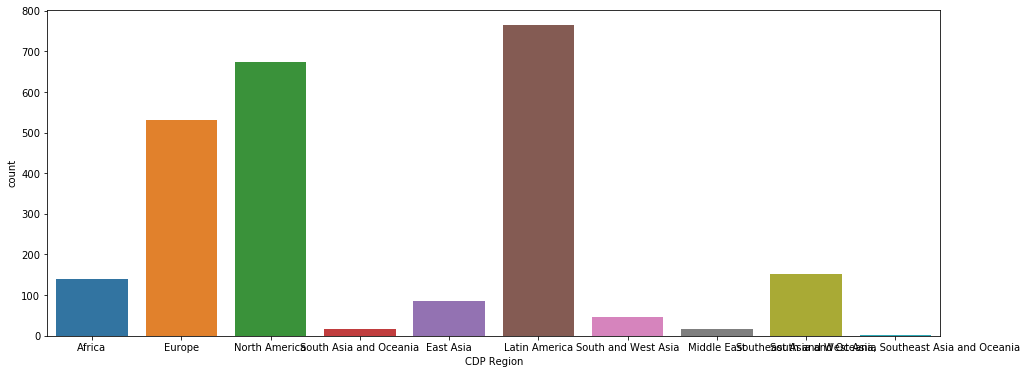

In [176]:
# Number of records (=cities) per region
fig, ax = plt.subplots(figsize=(16, 6))
sns.countplot(x = 'CDP Region', data = geo_data)

In [177]:
# Cities does not have a unique account number
print("---- On the full dataset ----")
print(f"Number of countries : {geo_data.groupby(by = 'Country')['Country'].count().size}")
print(f"Number of cities : {geo_data.groupby(by = 'City')['City'].count().size}")
print(f"Number of account number : {geo_data.groupby(by = 'Account number')['Account number'].count().size}")
print("\n---- Only for rows with emissions ----")
print(f"Number of countries : {geo_data[~has_no_emissions].groupby(by = 'Country')['Country'].count().size}")
print(f"Number of cities : {geo_data[~has_no_emissions].groupby(by = 'City')['City'].count().size}")
print(f"Number of account number : {geo_data[~has_no_emissions].groupby(by = 'Account number')['Account number'].count().size}")

---- On the full dataset ----
Number of countries : 108
Number of cities : 831
Number of account number : 1113

---- Only for rows with emissions ----
Number of countries : 81
Number of cities : 521
Number of account number : 632


In [178]:
# how many times does a city appear in the dataset?
geo_data['City'].value_counts().value_counts()

1     221
2     199
3     198
4      75
5      41
6      34
7      23
8      19
9      12
10      9
Name: City, dtype: int64

In [179]:
# How many cities recorded per country? (null value of cities are included, the top 20 countries are shown)
print(geo_data.groupby(by = 'Country')['Country'].count().sort_values(ascending = False)[:20])

Country
United States of America                                497
Brazil                                                  313
USA                                                     232
Argentina                                               170
Canada                                                  123
Italy                                                   100
Portugal                                                 99
Mexico                                                   94
Colombia                                                 85
Denmark                                                  68
Australia                                                64
United Kingdom of Great Britain and Northern Ireland     55
South Africa                                             52
Peru                                                     49
Sweden                                                   45
India                                                    36
Indonesia                       

In [180]:
# Let's see an example
geo_data[geo_data['Country']=='Colombia']

,Account number,Organization,City,Country,CDP Region,C40,Reporting authority,Access,City-wide emissions inventory,Administrative city boundary,Inventory boundary (compared to Administrative city boundary),Land area (in square km),City location,Country location,Average altitude (m),Average annual temperature (in Celsius)
4,31154,Bogotá Distrito Capital,Bogotá,Colombia,NaN,C40,NaN,NaN,NaN,NaN,NaN,NaN,"(4.598056, -74.075833)","(4.570868, -74.297333)",NaN,NaN
50,31154,Bogotá Distrito Capital,Bogotá,Colombia,NaN,C40,NaN,NaN,NaN,NaN,NaN,NaN,"(4.598056, -74.075833)","(4.570868, -74.297333)",NaN,NaN
101,36037,Santiago de Cali,Cali,Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(3.420556, -76.522222)","(4.570868, -74.297333)",NaN,NaN
111,31154,Bogotá Distrito Capital,Bogotá,Colombia,NaN,C40,NaN,NaN,NaN,NaN,NaN,NaN,"(4.598056, -74.075833)","(4.570868, -74.297333)",NaN,NaN
115,36037,Santiago de Cali,Cali,Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(3.420556, -76.522222)","(4.570868, -74.297333)",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3507,826237,Alcaldia de Madrid,Madrid (Colombia),Colombia,Latin America,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,120.50,POINT (-74.2642 4.73245),NaN,NaN,NaN
3548,35873,Municipality of Medellín,Medellín,Colombia,Latin America,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,376.40,POINT (-75.5735 6.22729),NaN,NaN,NaN
3553,848249,Corrales,NaN,Colombia,Latin America,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,60.85,NaN,NaN,NaN,NaN
3557,831152,Municipio de San Pedro de Urabá,San Pedro de Urabá,Colombia,Latin America,NaN,NaN,public,Intending to undertake in the next 2 years,City / Municipality,NaN,475.00,POINT (8.34552 -76.3414),NaN,NaN,NaN


## Can we infer city name from 'Organization' ?

In (I guess) all cases the name of the city can be extracted from Organization

The question is: does the emission measurment concerns only the city, or a breader area? 

I checked on some examples below and in many cases the area covered in the emission measurment is the city itself (when `Administrative city boundary = City / Municipality	` and `Inventory boundary = Same – covers entire city and nothing else`)

In [181]:
# Ratio of missing  values (%)
geo_data.isna().sum() / geo_data.shape[0] * 100

Account number                                                    0.000000
Organization                                                      0.000000
City                                                             16.934107
Country                                                           0.000000
CDP Region                                                       17.207238
C40                                                              91.259816
Reporting authority                                              51.519290
Access                                                           17.207238
City-wide emissions inventory                                    35.199727
Administrative city boundary                                     59.405941
Inventory boundary (compared to Administrative city boundary)    50.358484
Land area (in square km)                                         59.747354
City location                                                    20.587231
Country location         

In [182]:
# Can we infer the name of cities from 'Organization' when 'City' is missing ?

geo_data[geo_data['City'].isna()].sample(10)

,Account number,Organization,City,Country,CDP Region,C40,Reporting authority,Access,City-wide emissions inventory,Administrative city boundary,Inventory boundary (compared to Administrative city boundary),Land area (in square km),City location,Country location,Average altitude (m),Average annual temperature (in Celsius)
844,73690,Villa General Belgrano,NaN,Argentina,Latin America,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,Yes,NaN,Same – covers entire city and nothing else,NaN,NaN,NaN,NaN,NaN
2898,840529,Ayuntamiento de Victoria (Tamaulipas),NaN,Mexico,Latin America,NaN,NaN,public,In progress,City / Municipality,Larger – covers the whole city and adjoining a...,14113.294,NaN,NaN,NaN,NaN
3581,832097,Município de Lagos,NaN,Portugal,Europe,NaN,NaN,public,Intending to undertake in the next 2 years,City / Municipality,NaN,212.990,NaN,NaN,NaN,NaN
3106,58391,Maribyrnong City Council,NaN,Australia,Southeast Asia and Oceania,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,31.000,NaN,NaN,NaN,NaN
3135,827047,Fuzhou Municipal People's Government,NaN,China,East Asia,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,11968.000,NaN,NaN,NaN,NaN
1742,73665,Villa Pehuenia,NaN,Argentina,Latin America,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,Yes,NaN,Same – covers entire city and nothing else,NaN,NaN,NaN,NaN,NaN
2016,60307,Prefeitura de Nova Friburgo,NaN,Brazil,Latin America,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3061,848977,Busbanza,NaN,Colombia,Latin America,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,2549.000,NaN,NaN,NaN,NaN
3603,849121,Junín,NaN,Argentina,Latin America,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,2.253,NaN,NaN,NaN,NaN
742,832274,Município de Odemira,NaN,Portugal,Europe,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
# checking for some 'Account number' from the previous table if there is one record that contains the city name,
# but it is not the case
geo_data[
    geo_data['Account number'].isin([841491, 840244, 54349, 54270, 74643])
].sort_values(by = 'Account number')

,Account number,Organization,City,Country,CDP Region,C40,Reporting authority,Access,City-wide emissions inventory,Administrative city boundary,Inventory boundary (compared to Administrative city boundary),Land area (in square km),City location,Country location,Average altitude (m),Average annual temperature (in Celsius)
1328,54270,Palmerston North City Council,NaN,New Zealand,Southeast Asia and Oceania,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,Yes,NaN,Same – covers entire city and nothing else,NaN,NaN,NaN,NaN,NaN
2406,54270,Palmerston North City Council,NaN,New Zealand,Southeast Asia and Oceania,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,Yes,NaN,Same – covers entire city and nothing else,NaN,NaN,NaN,NaN,NaN
991,54349,Balikpapan City Government,NaN,Indonesia,Southeast Asia and Oceania,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,Yes,NaN,Same – covers entire city and nothing else,NaN,POINT (116.831 -1.26539),NaN,NaN,NaN
3030,54349,Balikpapan City Government,NaN,Indonesia,Southeast Asia and Oceania,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,503.330,POINT (116.831 -1.26539),NaN,NaN,NaN
3146,74643,Dijon métropole,NaN,France,Europe,NaN,NaN,public,Yes,Intercommunality,Same – covers entire city and nothing else,240.000,NaN,NaN,NaN,NaN
1144,840244,Prefeitura de Águas da Prata,NaN,Brazil,Latin America,NaN,"CDP Cities, ICLEI - Local Governments for Sust...",public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3426,840244,Prefeitura de Águas da Prata,NaN,Brazil,Latin America,NaN,NaN,public,Intending to undertake in the next 2 years,City / Municipality,NaN,142.673,NaN,NaN,NaN,NaN
3571,841491,Muar Municipal Council,NaN,Malaysia,Southeast Asia and Oceania,NaN,NaN,public,Yes,City / Municipality,Same – covers entire city and nothing else,1376.000,NaN,NaN,NaN,NaN


In [184]:
# This column is only present in 2020's report
geo_data['Administrative city boundary'].value_counts()

City / Municipality                                                                                                                                                                                                                            653
Administrative boundary of a local government                                                                                                                                                                                                  337
A metropolitan area                                                                                                                                                                                                                             49
Metropolitan area                                                                                                                                                                                                                               25
Local government area within

# Temporal coverage

- a bit of engineering is required to split start/end year in two separated columns
- most years are between 2014 and 2018 but ranges from 1990 to 2021
- in almost every cases the emissions are given over a one-year window

'Year Reported to CDP' and 'Last update' all have the same value in the same year's report (2020 for example)

In [185]:
data['Accounting year'].head(15)

0     2010
1     2010
2     2010
3     2009
4     2011
5     2010
6     2011
7     2010
8     2005
9     2010
10    2010
11    2010
12    2008
13    2010
14    2009
Name: Accounting year, dtype: object

### Splitting year start/end for the following datasets : 2013, 2017, 2018, 2019, 2020

In [193]:
# split 'Accounting year' in start/end date and cast to datetime format for year 2013, 2017 to 2020
data_to_split = data[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020])].copy()

data_to_split['Accounting year start'] = data_to_split['Accounting year'].str.split(' - ', n = 1, expand = True)[0]
data_to_split['Accounting year end'] = data_to_split['Accounting year'].str.split(' - ', n = 1, expand = True)[1]

#data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year start'] = pd.to_datetime(data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year start'], errors = 'coerce')
#data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year end'] = pd.to_datetime(data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year end'], errors = 'coerce')

In [194]:
data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year start'] = data_to_split['Accounting year start']
data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year end'] = data_to_split['Accounting year end']


In [195]:
data['Accounting year start'] = pd.to_datetime(data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year start'], errors = 'coerce')
data['Accounting year end'] = pd.to_datetime(data.loc[data['Reporting year'].isin([2013, 2017, 2018, 2019, 2020]), 'Accounting year end'], errors = 'coerce')

In [197]:
data[['Accounting year', 'Accounting year start', 'Accounting year end']].to_csv('accounting year split.csv', index=False)

In [202]:
data.loc[data['Reporting year'].isin([2015, 2016]), 'Accounting year']

198    12/31/2013 12:00:00 AM
199    12/31/2013 12:00:00 AM
200    12/31/2013 12:00:00 AM
201    06/30/2014 12:00:00 AM
202    12/31/2012 12:00:00 AM
                ...          
499    12/31/2015 12:00:00 AM
500    12/31/2012 12:00:00 AM
501    12/31/2012 12:00:00 AM
502    12/31/2012 12:00:00 AM
503    12/31/2014 12:00:00 AM
Name: Accounting year, Length: 306, dtype: object

### Converting to datetime for 2015, 2016
For these years we have only one date in accounting year. We have two cases : the date is a 1st January, or a 31st December.
When it is the begining of the year we will put it in start date and when it's at the end of the year we will put it in end date.
We have a few outliers (2014-06-30 for example)

In [201]:
# now we clean for 2015 and 2016
pd.to_datetime(data.loc[data['Reporting year'].isin([2015, 2016]), 'Accounting year'], errors = 'coerce')

198   2013-12-31
199   2013-12-31
200   2013-12-31
201   2014-06-30
202   2012-12-31
         ...    
499   2015-12-31
500   2012-12-31
501   2012-12-31
502   2012-12-31
503   2014-12-31
Name: Accounting year, Length: 306, dtype: datetime64[ns]

In [206]:
data_16['Accounting year'].to_excel('dates 2016.xlsx')

In [106]:
data['Accounting year start'].value_counts()

2016-01-01    319
2017-01-01    274
2018-01-01    273
2015-01-01    245
2014-01-01    208
             ... 
2009-01-03      1
2004-12-31      1
2012-07-01      1
2014-10-01      1
2009-07-01      1
Name: Accounting year start, Length: 111, dtype: int64

In [53]:
# there are many missing values
# in most cases both start/end date are missing
data[['Accounting year start', 'Accounting year end']].isna().sum()

Accounting year start     820
Accounting year end      1134
dtype: int64

In [54]:
# they are null both at same time 
data[ data['Accounting year start'].isna() & data['Accounting year end'].isna() ].shape[0]

820

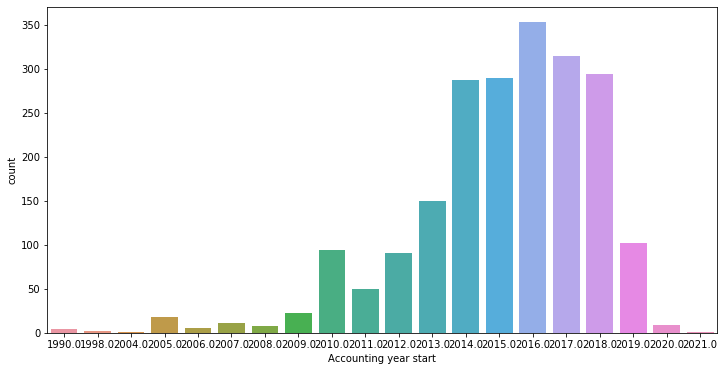

In [55]:
# distribution of 'Accounting year start'
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(x = data['Accounting year start'].dt.year)

In [56]:
# For which period of time are emissions given ?
(data['Accounting year end'] - data['Accounting year start']).value_counts()

364 days     1311
365 days      432
366 days       16
363 days        6
729 days        3
362 days        3
11 days         2
30 days         2
-1 days         2
361 days        2
367 days        2
1447 days       1
1778 days       1
211 days        1
2555 days       1
334 days        1
700 days        1
2922 days       1
273 days        1
396 days        1
899 days        1
368 days        1
2921 days       1
1095 days       1
0 days          1
dtype: int64

# Emissions analysis

Emissions data takes a very wide range of values (= many extreme values)
For each scope they are given as either:
- total emissions
- or split by including/excluding generation of grid-supplied energy
I decided to create a column 'Scope_X' to make analysis easier

Still need to check what are BASIC/BASIC+ emissions, but there are some explanation [in this document](https://ghgprotocol.org/sites/default/files/standards_supporting/GPC_Executive_Summary_1.pdf) from GPD.

In [ ]:
data.iloc[:, 15:29];

In [ ]:
# We create a column with the total emissions for each scope.
# It was verified that when we have 'TOTAL Scope 1 Emissions (metric tonnes CO2e)' we do not have the including/excluding grid supplied energy
# and vice-versa
# the rows with missing values are kept as missing values thanks to 'min_count=1'
data['Scope_1'] = data[
    ['Direct emissions (metric tonnes CO2e) for Total generation of grid-supplied energy',
    'Direct emissions (metric tonnes CO2e) for Total emissions (excluding generation of grid-supplied energy)',
     'TOTAL Scope 1 Emissions (metric tonnes CO2e)']
].sum(axis=1, min_count=1)

data['Scope_2'] = data[
    ['Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total generation of grid supplied energy',
    'Indirect emissions from use of grid supplied energy (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy)',
    'TOTAL Scope 2 emissions (metric tonnes CO2e)']
].sum(axis=1, min_count=1)

data['Scope_3'] = data[
    ['Emissions occurring outside city boundary (metric tonnes CO2e) for Total Generation of grid supplied energy',
    'Emissions occurring outside city boundary (metric tonnes CO2e) for Total Emissions (excluding generation of grid-supplied energy)',
    'TOTAL Scope 3 Emissions']
].sum(axis=1, min_count=1)

In [ ]:
# The data is terribly skewed, there are some values so high that we cannot plot it on an histogram
data[['Scope_1', 'Scope_2', 'Scope_3']].describe(percentiles=[0.25, 0.5, 0.75])

In [ ]:
data[['Scope_1', 'Scope_2', 'Scope_3']].skew(axis=0, skipna=True)

In [ ]:
# Top values for scope 1
data[['Country', 'Organization', 'Administrative city boundary','Scope_1']].sort_values(
    by='Scope_1', ascending=False)[:15]

In [ ]:
# Extreme values are filtered out so we can have a look at the distribution
fig, axes = plt.subplots(3, 1, figsize=(7, 7))
sns.histplot(x = data[data['Scope_1'] < 1e8].loc[:, 'Scope_1'], ax=axes[0])
sns.histplot(x = data[data['Scope_2'] < 1e8].loc[:, 'Scope_2'], ax=axes[1])
sns.histplot(x = data[data['Scope_3'] < 1e8].loc[:, 'Scope_3'], ax=axes[2])

In [ ]:
data['Scope_2'].isna().sum()

In [ ]:
data['Scope_1_std'] = (data['Scope_1'] - data['Scope_1'].mean()) / data['Scope_1'].std()

In [ ]:
data['Scope_1'].mean()

In [ ]:
sns.histplot(x=data[
    data['Scope_1_std'] <= data['Scope_1_std'].mean() + 3*data['Scope_1_std'].std() & data['Scope_1_std'] >= data['Scope_1_std'].mean() - 3*data['Scope_1_std'].std()
]['Scope_1_std'])

In [ ]:
data['Scope_1_std']

# Gazes included

In [ ]:
data['Gases Included'].value_counts()

In [ ]:
data_16['Gases included'].value_counts()

In [ ]:
data_17['Gases included'].value_counts()

In [ ]:
data_18['Gases Included'].value_counts()